In [1]:
# 필요한 패키지 import 하기
import os # 환경 변수나 디렉터리, 파일 등의 OS 자원을 제어할 수 있게 해주는 모듈
import cv2 # OpenCV라이브러리 → 컴퓨터 비전 관련 프로그래밍을 쉽게 할 수 있도록 도와주는 라이브러리
import matplotlib.pyplot as plt # 다양한 데이터를 많은 방법으로 도식화 할 수 있도록 하는 라이브러리
import numpy as np # 다차원 배열을 쉽게 처리하고 효율적으로 사용할 수 있도록 하는 라이브러리
import dlib # 이미지 처리 및 기계 학습, 얼굴인식 등을 할 수 있는 c++ 로 개발된 고성능의 라이브러리 

## 사진 준비하기

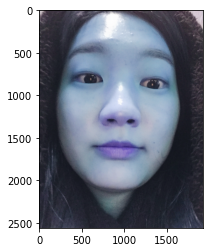

In [2]:
my_image_path = '/aiffel/aiffel/face_detection/face.png' 
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러오기
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관
plt.imshow(img_bgr) # 이미지를 출력하기 위해 출력할 이미지를 올려준다. (실제 출력은 하지 않음)
plt.show() # 이미지를 출력해준다. (실제 출력)

BGR -> RGB

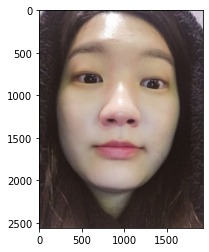

In [3]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb) # 이미지 실제 출력하기 위해 이미지를 올려줌 
plt.show() # 이미지 실제 출력

## Hog detector 사용해서 얼굴 찾기

In [6]:
detector_hog = dlib.get_frontal_face_detector() 

In [7]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

## bounding box 그리기

rectangles[[(148, 332) (1804, 1988)]]


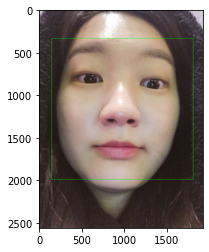

In [8]:
# 찾은 얼굴 영역 박스 리스트

print(dlib_rects)   

for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

dlib에서 제공하는 landmark 모델

In [10]:
model_path = '/aiffel/aiffel/face_detection/shape_predictor_68_face_landmarks.dat'
    
landmark_predictor = dlib.shape_predictor(model_path)
# landmark_predictor는 RGB이미지와 dlib.rectangle를 입력 받고 dlib.full_object_detection를 반환
# dlib.full_object_detection: 각 구성 요소의 위치와, 이미지 상의 객체의 위치를 나타냄

In [11]:
list_landmarks = [] #landmark의 위치를 저장하는 list
   
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
        # 모든 landmark의 위치정보를 points 변수에 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        # 각각의 landmark 위치정보를 (x,y) 형태로 변환하여 list_points 리스트로 저장
    list_landmarks.append(list_points)
        # list_landmarks에 랜드마크 리스트를 저장

print(len(list_landmarks[0]))
   

68


## point 위에 점찍기!

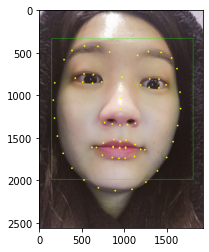

In [12]:
# list_landmarks의 원소가 1개이므로 아래 반복문은 한번만 실행됨
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 10, (0, 255, 255), -1)
              # img_show 이미지 위 각각의 point에 크기가 2이고 (0, 255, 255)색으로 내부가 채워진(-1) 원을 그림
            
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    # RGB 이미지로 전환
plt.imshow(img_show_rgb)
    # 이미지를 준비
plt.show()
    # 이미지를 출력

## 수염 넣을 좌표 지정하기

In [13]:
# 좌표 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print ('코끝의 위치: ', landmark[33]) # nose edge index : 33
    x = landmark[33][0] # 수염의 중앙 x좌표값
    y = landmark[33][1] # 수염의 중앙 y좌표값
    w = dlib_rect.width() # 수염 스티커 resize를 위한 경계박스 너비
    h = dlib_rect.width() # 수염 스티커 resize를 위한 경계박스 높이
    print ('(x,y) : (%d,%d)'%(x,y)) 
    print ('(w,h) : (%d,%d)'%(w,h)) 

코끝의 위치:  (948, 1353)
(x,y) : (948,1353)
(w,h) : (1657,1657)


## 수염 이미지 불러오기 & resize

In [14]:
sticker_path = os.getenv('HOME')+'/aiffel/face_detection/cat-whiskers.png' 
img_sticker = cv2.imread(sticker_path) 
img_sticker = cv2.resize(img_sticker,(w,h)) #위에서 설정했던 w,h 확인

print (img_sticker.shape) 

(1657, 1657, 3)


In [16]:
refined_x = x - w // 2 
refined_y = y - h // 2
# 원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정. 이미지 시작점은 top-left 좌표이기 때문입니다.
# 즉, refined_x, refined_y값에서 수염 이미지가 시작됨
print (f'(x,y) : ({refined_x},{refined_y})') # 이 과정에서 만약 음수값이 발생하면, 이미지 범위를 벗어나는 것을 의미한다.

(x,y) : (120,525)


In [16]:
#윗단계에서 음수가 나올 경우 처리하는 방법
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0

if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :] 
    refined_y = 0

print (f'(x,y) : ({refined_x},{refined_y})')

(x,y) : (120,525)


## 원본 이미지에 스티커 적용
- 이 과정에서 sticker_area, img_show, img_sticker의 shape이 맞지 않아, value Error가 발생했었다.
  위에 w,h 값을 다시 조정해줌으로써 문제 해결.

In [17]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]


img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
# np.where는 조건에 해당하는 인덱스만 찾아서 값을 적용하는 방법

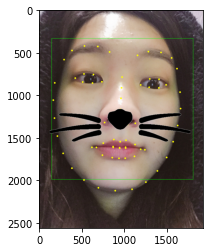

In [18]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## bounding box 적용하기 전 원본 이미지(img_bgr)에 수염 이미지 덮어 씌우기

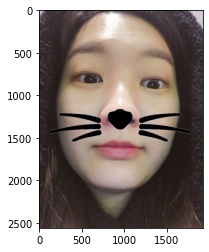

In [19]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
# img_bgr은 rgb로만 적용해놓은 원본 이미지이다. 
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)) # rgb만 적용해놓은 원본 이미지에 왕관 이미지를 덮어 씌운 이미지가 나오게 된다.
plt.show()

## 회고
- 큰 흐름을 이해하는 것이 늘 목적인데, 해보지 않은 작업이다 보니 흐름을 이해하는 데에 시간이 좀 걸렸다.
- 변수를 제대로 이해하고 넘어가지 않았더니, 수염 넣을 좌표 설정하는 것이 어려웠다.
- 지금은 정면인 얼굴만 나와있는 사진인데, 얼굴이 다른쪽을 바라보고 있거나 아주 멀리있다면?
- 발생할 수 있는 문제점 생각해보고, 해결 방법 찾아보기
- 참고한 링크  
https://shinest-programming.tistory.com/53